## Create figure similar to Joakim Kjellson's T-S cycle

Fig. 8: https://www.sciencedirect.com/science/article/pii/S1463500315001560

"Monthly averages of T and S at the surface and 500 m depth in the Weddell Sea for the years 1979–1992 for all runs listed in Table 1. February (warm, fresh) is shown by diamonds and September (cold, salty) by circles. Solid lines show potential density referenced to the surface, σ 0 . Red dashed lines show the observed potential density at the surface and 500 m in September. Thick solid black line shows the freezing point of sea water."

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import plot_ts_distribution
from nemo_python_git.constants import gravity, rho_fw

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'

In [3]:
# regions:
weddell_basin      = {'x': slice(950, 1150, None), 'y': slice(295, 360, None)} # very similar to weddell convect but withwout shelf edge
weddell_west_shelf = {'x': slice(918, 967, None), 'y': slice(245, 310, None)}
weddell_overall    = {'x': slice(850, 1200, None), 'y': slice(50, -1, None)}

## Convective resistance

In [5]:
# Function to calculate the convective resistance --- the buoyance loss required to overturn the water column 
# to a given depth, H (Campbell et al. 2019; Gulk et al., 2024)
# Inputs:
# dsT    : xarray dataset containing variables "so", "thetao", and "deptht"
# ds_mesh: xarray dataset containing variable "e3t_0", the grid cell vertical thicknesses
# H      : (optional) water column convection depth
def convective_resistance(dsT, ds_mesh, H=830):
    import gsw

    # calculate density referenced to 0 dbar from conservative temperature and absolute salinity
    rho = gsw.density.sigma0(dsT.so, dsT.thetao)
    # find depth level index closest to H:
    Hind = np.argmin(abs(dsT.deptht.values - H))

    # calculate potential density anomaly w.r.t reference pressure of 0 dbar
    rho_0H = rho.where(dsT.so!=0).isel(deptht=Hind)
    rho_0z = rho.where(dsT.so!=0).isel(deptht=slice(0,Hind))
    integrand = (rho_0H - rho_0z)*ds_mesh.e3t_0.isel(deptht=slice(0,Hind)) 
    CR = (gravity/rho_fw) * integrand.sum(dim='deptht') 

    return CR

In [5]:
run_dir  = f'{base_dir}output/ERA5_test9/'

gridT_files = np.sort(glob.glob(f'{run_dir}files/*grid_T*'))
dsT     = xr.open_dataset(gridT_files[-2]).isel(time_counter=4).rename({'y_grid_T':'y', 'x_grid_T':'x'})#.isel(**weddell_overall)
ds_mesh = xr.open_dataset(nemo_mesh).squeeze().rename({'nav_lev':'deptht'})#.isel(**weddell_overall)

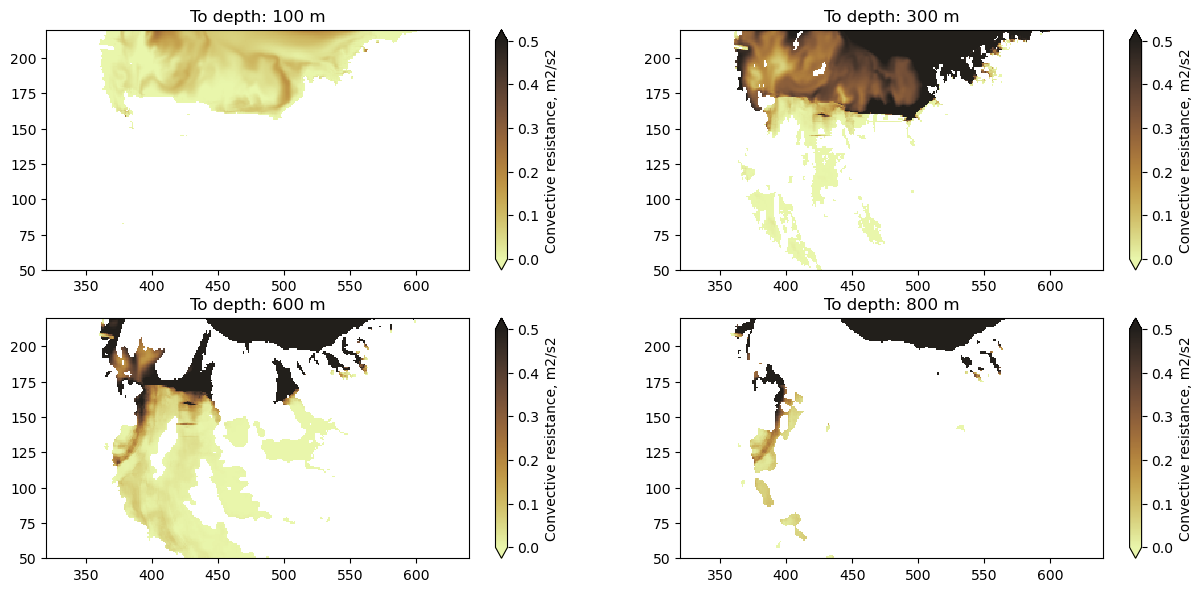

In [30]:
fig, ax = plt.subplots(2,2, figsize=(15,7), dpi=100)

Hs = [100, 300, 600, 800]
for a, axis in enumerate(ax.ravel()):
    CR = convective_resistance(dsT, ds_mesh, H=Hs[a])
    cm = axis.pcolormesh(dsT.x, dsT.y, CR.where(CR!=0), cmap=cmocean.cm.turbid, vmin=0, vmax=0.5)
    axis.plot([110, 150, 182, 250], [220, 275, 190, 280], '*k')
    axis.set_xlim(320,640)
    axis.set_ylim(50,220)
    axis.set_title(f'To depth: {Hs[a]} m')
    fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=axis)

In [ ]:
data_arrays = [] # create empty list to store xarray data arrays
# for loop to add data arrays to list
for depth in ds_mesh.deptht:
    print(depth)
    CR = convective_resistance(dsT.isel(x=425, y=slice(20,250)), ds_mesh.isel(x=425, y=slice(20,250)), H=depth.values)
    data_arrays.append(CR)
# concatenate list of data arrays along new dimension into xarray dataset
ds_CR = xr.concat(data_arrays, dim='H')

In [38]:
ds_CR = xr.concat(data_arrays, dim='H')

Text(0.5, 1.0, 'Ross ice shelf: x=425, y=20:300')

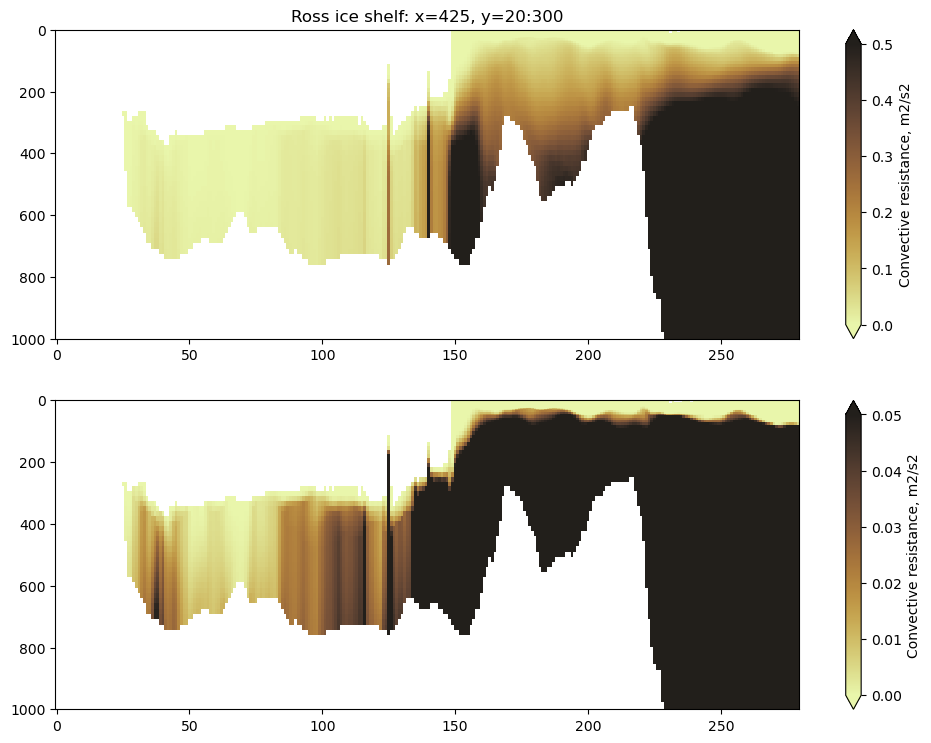

In [61]:
fig, ax = plt.subplots(2,1, figsize=(12,9), dpi=100)

x=425; y=slice(20, 300);
vmaxs=[0.5, 0.05]
for a, axis in enumerate(ax.ravel()):
    cm = axis.pcolormesh(dsT.isel(y=y).y, dsT.deptht, ds_CR.isel(x=x, y=y).where(ds_CR.isel(x=x, y=y)),
                         cmap=cmocean.cm.turbid, vmin=0, vmax=vmaxs[a])
    axis.set_ylim(1000,0)
    fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=axis)

ax[0].set_title('Ross ice shelf: x=425, y=20:300')

Text(0.5, 1.0, 'FRIS: x=990, y=110:260')

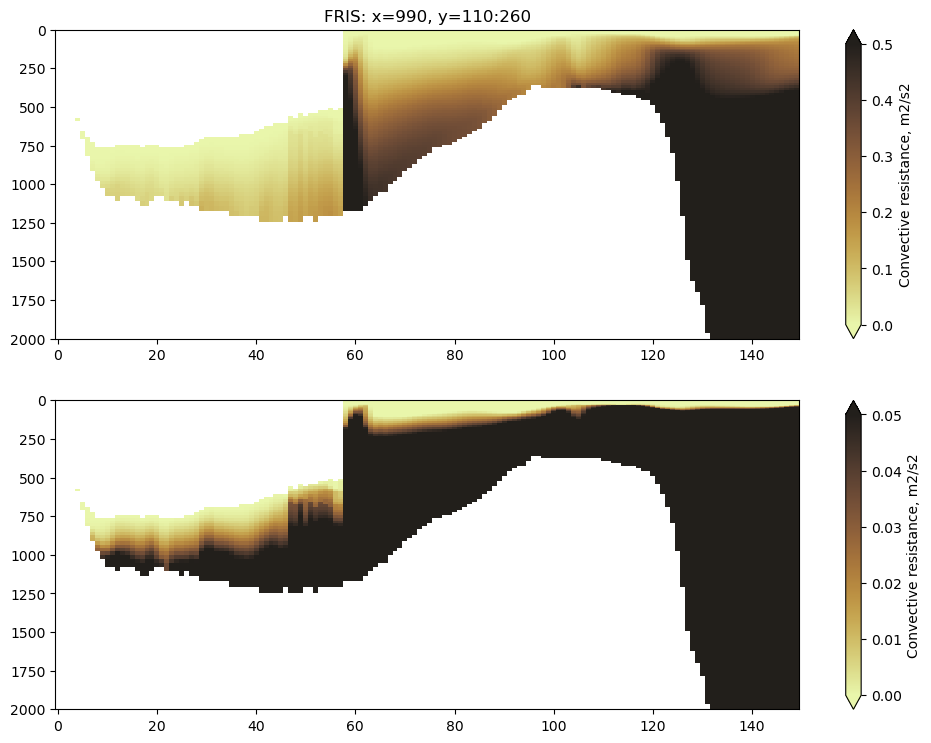

In [71]:
fig, ax = plt.subplots(2,1, figsize=(12,9), dpi=100)

x=990; y=slice(110, 260);
vmaxs=[0.5, 0.05]
for a, axis in enumerate(ax.ravel()):
    cm = axis.pcolormesh(dsT.isel(y=y).y, dsT.deptht, ds_CR.isel(x=x, y=y).where(ds_CR.isel(x=x, y=y)),
                         cmap=cmocean.cm.turbid, vmin=0, vmax=vmaxs[a])
    axis.set_ylim(2000,0)
    fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=axis)

ax[0].set_title('FRIS: x=990, y=110:260')

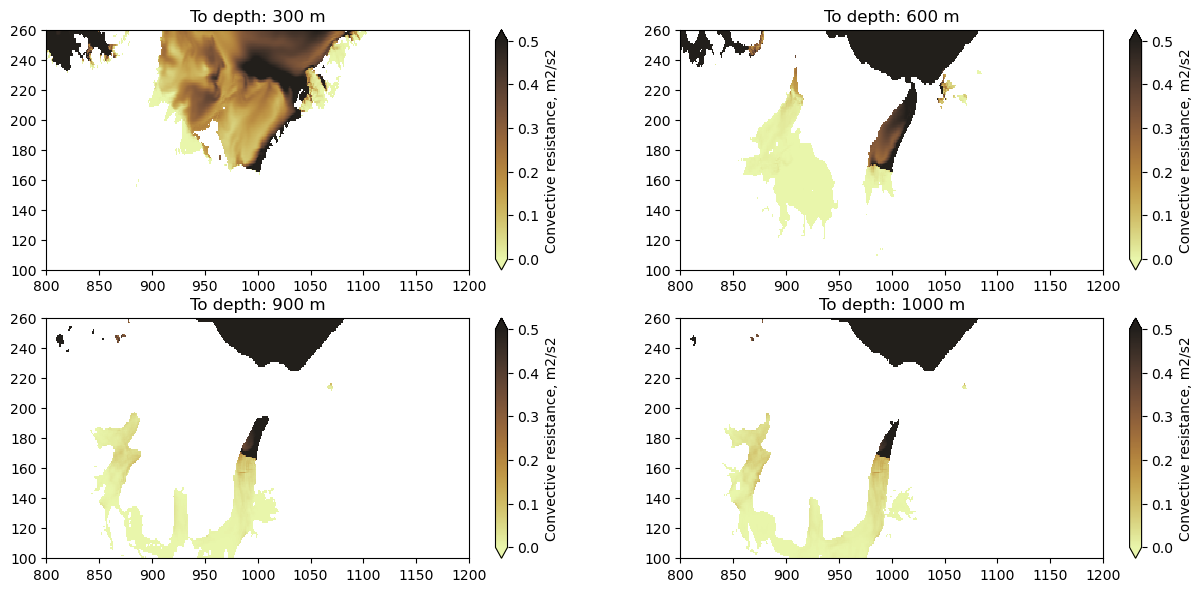

In [63]:
fig, ax = plt.subplots(2,2, figsize=(15,7), dpi=100)

Hs = [300, 600, 900, 1000]
for a, axis in enumerate(ax.ravel()):
    CR = convective_resistance(dsT, ds_mesh, H=Hs[a])
    cm = axis.pcolormesh(dsT.x, dsT.y, CR.where(CR!=0), cmap=cmocean.cm.turbid, vmin=0, vmax=0.5)
    axis.plot([110, 150, 182, 250], [220, 275, 190, 280], '*k')
    axis.set_xlim(800,1200)
    axis.set_ylim(100,260)
    axis.set_title(f'To depth: {Hs[a]} m')
    fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=axis)

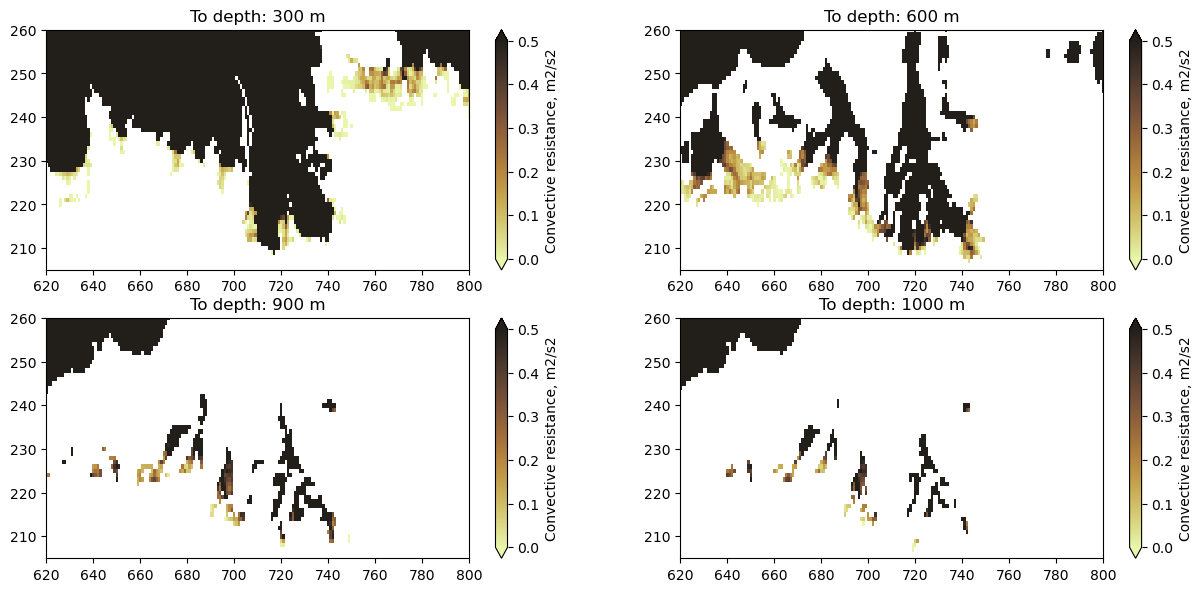

In [22]:
fig, ax = plt.subplots(2,2, figsize=(15,7), dpi=100)

Hs = [300, 600, 900, 1000]
for a, axis in enumerate(ax.ravel()):
    CR = convective_resistance(dsT, ds_mesh, H=Hs[a])
    cm = axis.pcolormesh(dsT.x, dsT.y, CR.where(CR!=0), cmap=cmocean.cm.turbid, vmin=0, vmax=0.5)
    axis.plot([110, 150, 182, 250], [220, 275, 190, 280], '*k')
    axis.set_xlim(620,800)
    axis.set_ylim(205,260)
    axis.set_title(f'To depth: {Hs[a]} m')
    fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=axis)

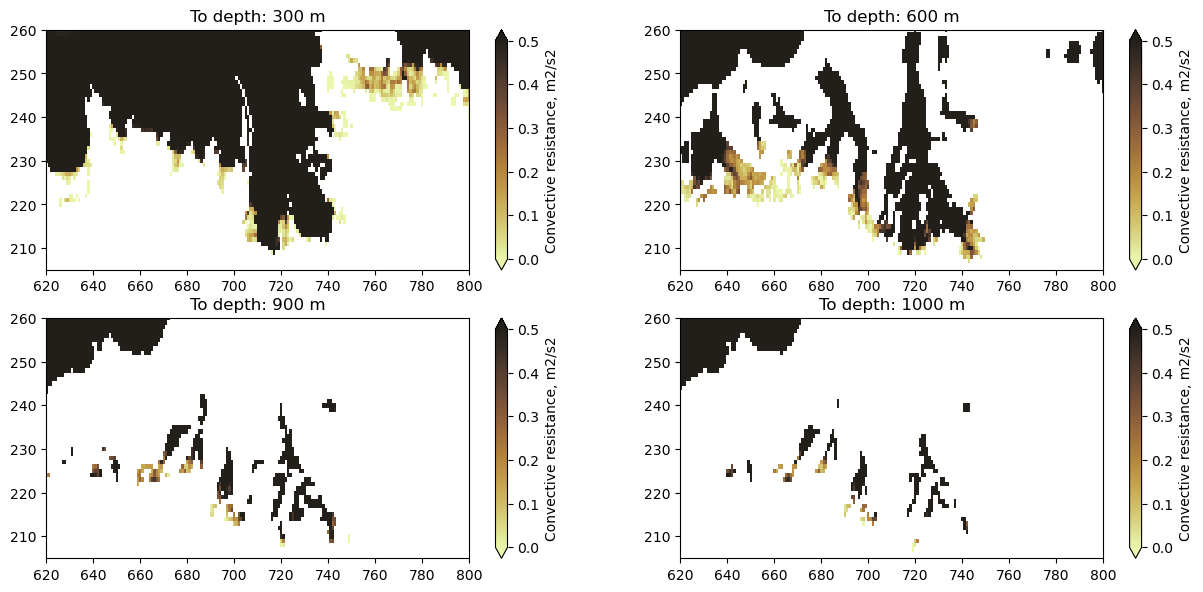

In [17]:
fig, ax = plt.subplots(2,2, figsize=(15,7), dpi=100)

Hs = [300, 600, 900, 1000]
for a, axis in enumerate(ax.ravel()):
    CR = convective_resistance(dsT, ds_mesh, H=Hs[a])
    cm = axis.pcolormesh(dsT.x, dsT.y, CR.where(CR!=0), cmap=cmocean.cm.turbid, vmin=0, vmax=0.5)
    axis.plot([110, 150, 182, 250], [220, 275, 190, 280], '*k')
    axis.set_xlim(620,800)
    axis.set_ylim(205,260)
    axis.set_title(f'To depth: {Hs[a]} m')
    fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=axis)

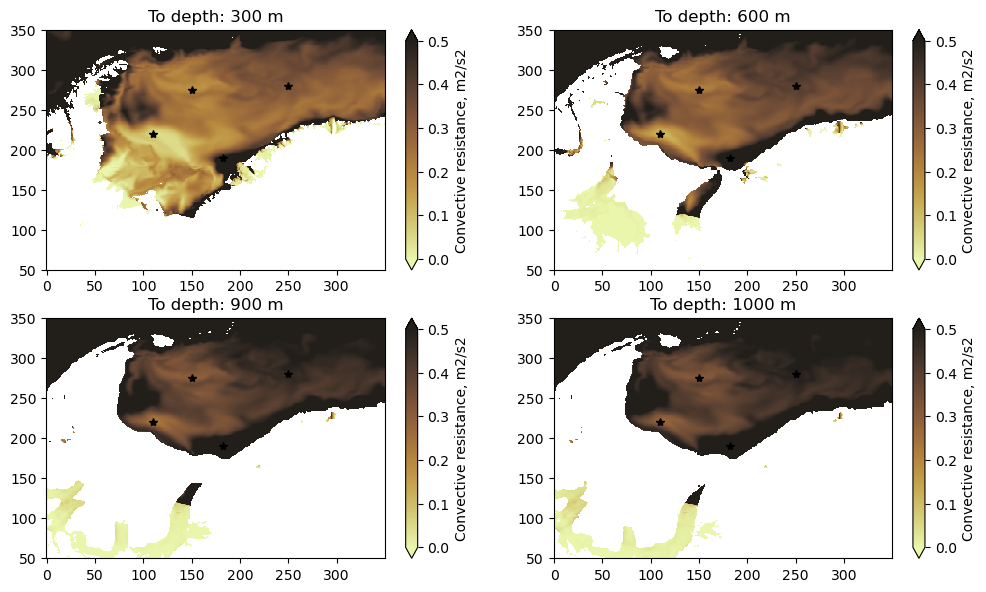

In [64]:
fig, ax = plt.subplots(2,2, figsize=(12,7), dpi=100)

Hs = [300, 600, 900, 1000]
for a, axis in enumerate(ax.ravel()):
    CR = convective_resistance(dsT, ds_mesh, H=Hs[a])
    cm = axis.pcolormesh(dsT.x, dsT.y, CR.where(CR!=0), cmap=cmocean.cm.turbid, vmin=0, vmax=0.5)
    axis.plot([110, 150, 182, 250], [220, 275, 190, 280], '*k')
    axis.set_ylim(50,350)
    axis.set_title(f'To depth: {Hs[a]} m')
    fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=axis)

In [221]:
Ts = np.arange(-2.4, 0, 0.05)
Ss = np.arange(33, 35, 0.01)

Tgrid, Sgrid = np.meshgrid(Ts, Ss)

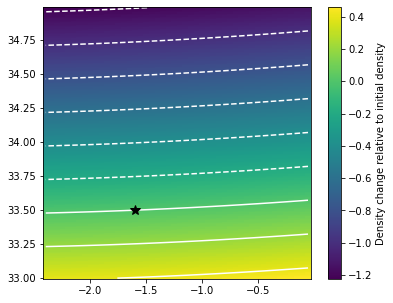

In [224]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

density_change = gsw.density.sigma0(33.5, -1.6) - gsw.density.sigma0(Sgrid, Tgrid)
cm = ax.pcolormesh(Tgrid, Sgrid, density_change)
ax.contour(Tgrid, Sgrid, density_change, colors='w', levels=[-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4])
ax.plot([-1.6], [33.5], '*k', markersize=10)
fig.colorbar(cm, label='Density change relative to initial density')

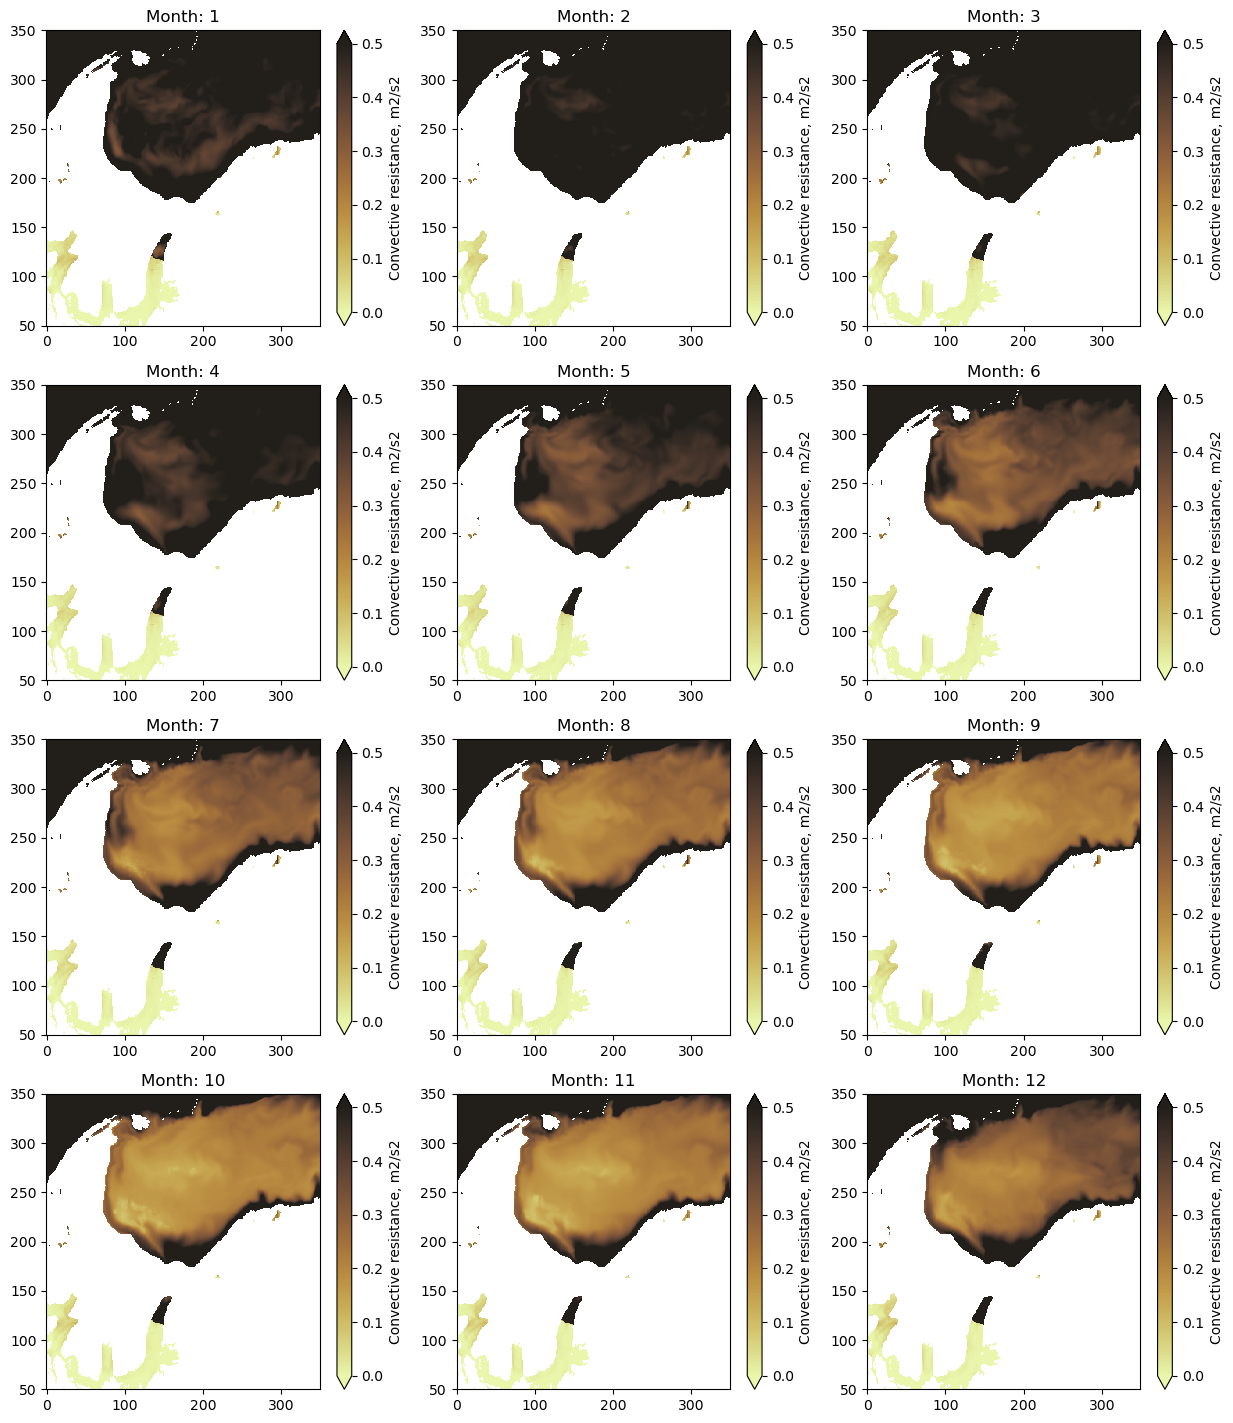

In [18]:
fig, ax = plt.subplots(4,3, figsize=(15,18), dpi=100)

dsT = xr.open_dataset(gridT_files[0]).rename({'y_grid_T':'y', 'x_grid_T':'x'}).isel(**weddell_overall)
for a, axis in enumerate(ax.ravel()):
    dsT_month = dsT.isel(time_counter=a)
    CR = convective_resistance(dsT_month, ds_mesh, H=900)
    cm = axis.pcolormesh(dsT.x, dsT.y, CR.where(CR!=0), cmap=cmocean.cm.turbid, vmin=0, vmax=0.5)
    axis.set_ylim(50,350)
    axis.set_title(f'Month: {a+1}')
    fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=axis)

#### Timeseries of convective resistance at a few key locations

In [10]:
run_dir  = f'{base_dir}output/ERA5_test9/'
gridT_files  = np.sort(glob.glob(f'{run_dir}files/*grid_T*'))
icemod_files = np.sort(glob.glob(f'{run_dir}files/*icemod*'))
dsT     = xr.open_mfdataset(gridT_files).rename({'y_grid_T':'y', 'x_grid_T':'x'}).isel(**weddell_overall)
ice     = xr.open_mfdataset(icemod_files).isel(**weddell_overall)
ds_mesh = xr.open_dataset(nemo_mesh).squeeze().isel(**weddell_overall).rename({'nav_lev':'deptht'})

In [11]:
CR = convective_resistance(dsT, ds_mesh, H=600)
CR = CR.where(CR!=0)

In [12]:
x_inds = [110, 150, 182, 250]
y_inds = [220, 275, 190, 280]
colors = ['#ff6f69','#96ceb4','#ffcc5c','#5c8fff']

Text(0, 0.5, 'Convective resistance, m2/s2')

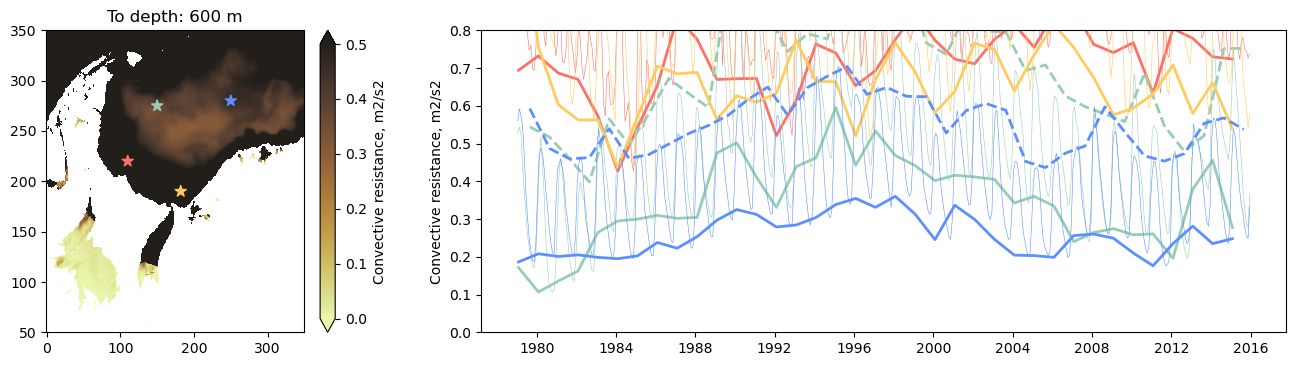

In [9]:
fig, ax = plt.subplots(1,2, figsize=(16,4), dpi=100, gridspec_kw={'width_ratios':[1, 2.5]})

cm = ax[0].pcolormesh(dsT.x, dsT.y, CR.where(CR!=0).isel(time_counter=4), cmap=cmocean.cm.turbid, vmin=0, vmax=0.5)
ax[0].scatter(x_inds, y_inds, c=colors, marker='*', s=70)
ax[0].set_ylim(50,350)
ax[0].set_title(f'To depth: 600 m')
fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=ax[0])

for i, (xind, yind) in enumerate(zip(x_inds, y_inds)):
    yearly_min = CR.isel(x=xind, y=yind).resample(time_counter='1Y').min()
    yearly_max = CR.isel(x=xind, y=yind).resample(time_counter='1Y').max()
    ax[1].plot(CR.isel(x=xind, y=yind).time_counter, CR.isel(x=xind, y=yind), c=colors[i], linewidth=0.4)
    ax[1].plot((yearly_min.time_counter - np.timedelta64(334,'D')), yearly_min, c=colors[i], linewidth=2, linestyle='-')
    ax[1].plot((yearly_max.time_counter - np.timedelta64(126,'D')), yearly_max, c=colors[i], linewidth=2, linestyle='--')

ax[1].set_ylim(0, 0.8)
ax[1].set_ylabel('Convective resistance, m2/s2')

In [ ]:
run_dir  = f'{base_dir}output/ERA5_test6/'
gridT_files = np.sort(glob.glob(f'{run_dir}files_spinup/*grid_T*'))
dsT     = xr.open_mfdataset(gridT_files).rename({'y_grid_T':'y', 'x_grid_T':'x'}).isel(**weddell_overall)
ds_mesh = xr.open_dataset(nemo_mesh).squeeze().isel(**weddell_overall).rename({'nav_lev':'deptht'})
CR = convective_resistance(dsT, ds_mesh, H=600)
CR = CR.where(CR!=0)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,4), dpi=100, gridspec_kw={'width_ratios':[1, 2.5]})

cm = ax[0].pcolormesh(dsT.x, dsT.y, CR.where(CR!=0).isel(time_counter=4), cmap=cmocean.cm.turbid, vmin=0, vmax=0.5)
ax[0].scatter(x_inds, y_inds, c=colors, marker='*', s=70)
ax[0].set_ylim(50,350)
ax[0].set_title(f'To depth: 600 m')
fig.colorbar(cm, label='Convective resistance, m2/s2', extend='both', ax=ax[0])

for i, (xind, yind) in enumerate(zip(x_inds, y_inds)):
    yearly_min = CR.isel(x=xind, y=yind).groupby('time_counter.year').min()
    yearly_max = CR.isel(x=xind, y=yind).groupby('time_counter.year').max()
    ax[1].plot(CR.isel(x=xind, y=yind).time_counter, CR.isel(x=xind, y=yind), c=colors[i], linewidth=0.4)
    ax[1].plot((yearly_min.time_counter - np.timedelta64(334,'D')), yearly_min, c=colors[i], linewidth=2, linestyle='-')
    ax[1].plot((yearly_max.time_counter - np.timedelta64(126,'D')), yearly_max, c=colors[i], linewidth=2, linestyle='--')

ax[1].set_ylim(0, 0.8)
ax[1].set_ylabel('Convective resistance, m2/s2')

Correlate with conditions

In [13]:
sea_ice_area    = ice.siconc * dsT.area_grid_T
# calculate maximum sea ice area by year
annual_seaice_area  = sea_ice_area.sum(['y','x']).groupby('time_counter.year')
# monthly_seaice_area = sea_ice_area.sum(['y','x']).groupby('time_counter.month') 

0
1
2
3


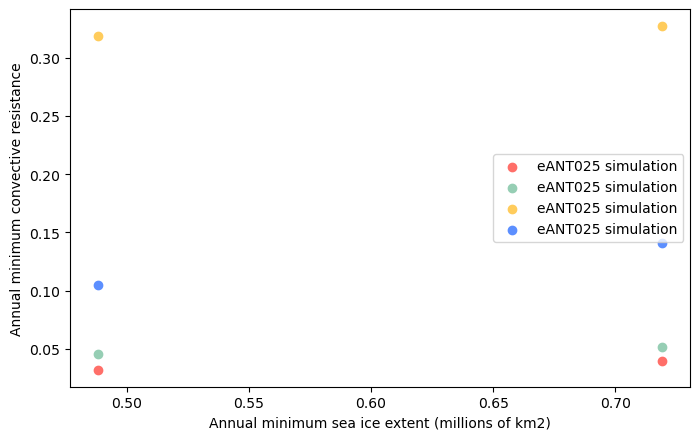

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8, 5), dpi=100)

for i, (xind, yind) in enumerate(zip(x_inds[0:3], y_inds[0:3])):
    print(i)
    yearly_min = CR.isel(x=xind, y=yind).groupby('time_counter.year').min()
    ax.scatter(annual_seaice_area.min()*1e-12, yearly_min, c=colors[i])
ax.set_xlabel('Annual minimum sea ice extent (millions of km2)')
ax.set_ylabel('Annual minimum convective resistance')

### T-S diagram

In [3]:
ds_mesh = xr.open_dataset(nemo_mesh)
zind_surf = 0 
zind_500  = 50

## weddell sea mask:


In [5]:
# load nemo simulations
gridT_files = glob.glob(f'{run_dir}files/*grid_T*')[0:2] # load all the gridT files in the run folder
nemo_ds = xr.open_mfdataset(gridT_files).rename({'x_grid_T':'x','y_grid_T':'y'}) 

In [11]:
kwags1 = {'x':weddell_overall['x'], 'y':weddell_overall['y'], 'time_counter':(nemo_ds.time_counter.dt.month==9)}

zind = zind_surf
salt = nemo_ds.so.isel(deptht=zind, **kwags1).mean(dim='time_counter')
salt = salt.where(salt!=0)
temp = nemo_ds.thetao.isel(deptht=zind, **kwags1).mean(dim='time_counter')
temp = temp.where(temp!=0)

density_surf = gsw.density.sigma0(salt, temp)

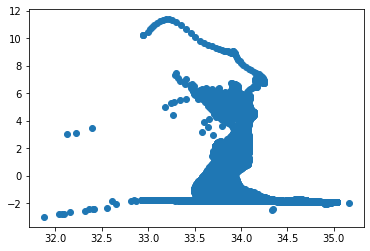

In [14]:
plt.scatter(salt, temp)

KeyboardInterrupt: 

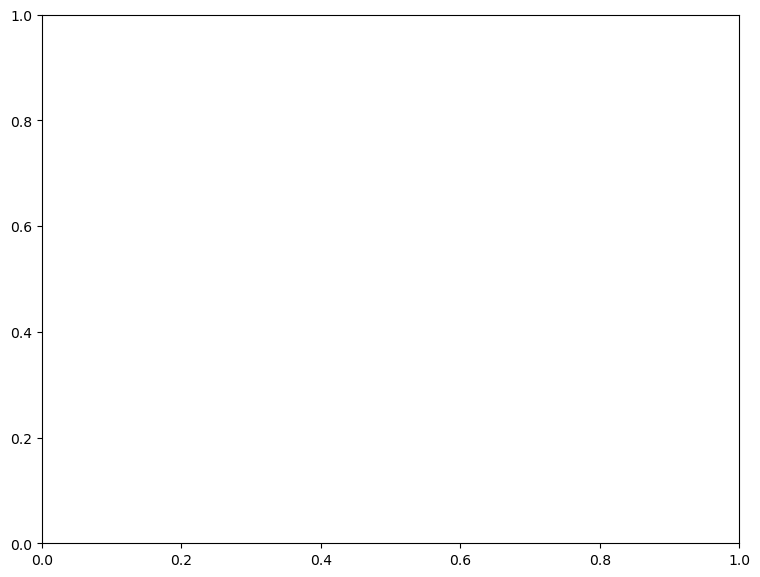

In [31]:
fig, ax = plt.subplots(1,1,figsize=(9,7), dpi=100)

years = np.unique(nemo_ds.time_counter.dt.year)

# for year in years: 
#     kwags = {'x':weddell_overall['x'], 'y':weddell_overall['y'], 
#              'time_counter':(nemo_ds.time_counter.dt.year==year) | (nemo_ds.time_counter.dt.year==year+1)*(nemo_ds.time_counter.dt.month==1)}
#     salt_500  = nemo_ds.so.isel(deptht=zind_500, **kwags)
#     temp_500  = nemo_ds.thetao.isel(deptht=zind_500, **kwags)
#     salt_surf = nemo_ds.so.isel(deptht=zind_surf, **kwags)
#     temp_surf = nemo_ds.thetao.isel(deptht=zind_surf, **kwags)

#     salt_500  = salt_500.where(salt_500!=0).mean(dim=['x','y']) 
#     temp_500  = temp_500.where(temp_500!=0).mean(dim=['x','y']) 
#     salt_surf = salt_surf.where(salt_surf!=0).mean(dim=['x','y']) 
#     temp_surf = temp_surf.where(temp_surf!=0).mean(dim=['x','y']) 

#     ax.plot(salt_surf, temp_surf, '-o') # add color for year
#     ax.plot(salt_500, temp_500, '-o')

# Red dashed lines show the observed potential density at the surface and 500 m in September.
kwags1 = {'x':weddell_overall['x'], 'y':weddell_overall['y'], 'time_counter':(nemo_ds.time_counter.dt.month==9)}
density_surf = gsw.density.sigma0(nemo_ds.so.isel(deptht=zind_surf, **kwags1).mean(dim='time_counter'), 
                                  nemo_ds.thetao.isel(deptht=zind_surf,**kwags1).mean(dim='time_counter'))
density_500  = gsw.density.sigma0(nemo_ds.so.isel(deptht=zind_500, **kwags1).mean(dim='time_counter'), 
                                  nemo_ds.thetao.isel(deptht=zind_500,**kwags1).mean(dim='time_counter'))

ax.contour(nemo_ds.so.isel(deptht=zind_surf, **kwags1).mean(dim='time_counter'), 
           nemo_ds.thetao.isel(deptht=zind_surf, **kwags1).mean(dim='time_counter'), 
           density_surf, colors='red', linestyles='dashed', zorder=2)
ax.contour(nemo_ds.so.isel(deptht=zind_500, **kwags1).mean(dim='time_counter'), 
           nemo_ds.thetao.isel(deptht=zind_500, **kwags1).mean(dim='time_counter'), 
           density_500, colors='red', linestyles='dashed', zorder=2)

ax.set_xlabel('Absolute Salinity')
ax.set_ylabel('Conservative Temperature')

In [ ]:
nemo_ds.so.isel(deptht=zind_surf, **kwags1).mean(dim='time_counter')

In [ ]:
# Function to plot a 2D histogram of temperature and salinity values on an axis you pass it
# Inputs:
# ax           : matplotlib axis
# salt         : absolute salinity
# temp         : conservative temperature
# smin, smax, tmin, tmax : (optional) bounds for the salinity and temperature axes
# plot_density : (optional) boolean specifying whether to plot dashed lines of constant potential density in the background
# plot_freeze  : (optional) boolean specifying whether to plot dashed line of surface freezing temperature in the background
# lognorm      : (optional) boolean specifying whether to log normalize the histogram counts
# bins         : (optional) number of bins of histogram
def plot_ts(ax, salt, temp, smin=30, smax=35.25, tmin=-3, tmax=2.25, plot_density=False, 
            plot_freeze=False):

    import gsw
    import gsw.freezing as fr

    # Plot surface freezing temperature line
    if plot_freeze:
        tfreeze_sfc = fr.CT_freezing(np.linspace(smin, smax), 0, 0) # saturation_fraction=0
        ax.plot(np.linspace(smin, smax), tfreeze_sfc, color='black', linestyle='dashed', zorder=1)

    # Plot contours of potential density
    if plot_density:
        salt_2d, temp_2d = np.meshgrid(np.linspace(smin, smax), np.linspace(tmin, tmax))
        density = gsw.density.sigma0(salt_2d, temp_2d)
        ax.contour(salt_2d, temp_2d, density, colors='DarkGrey', linestyles='dotted', zorder=2)
    
    
    ax.set_xlim(smin, smax)
    ax.set_ylim(tmin, tmax)
    ax.set_xlabel('Absolute Salinity')
    ax.set_ylabel('Conservative Temperature')

    return

In [4]:
def extract_region_var(run_dir, var_name, region, file_slice=(0,None)):
    nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=region['x'], y=region['y']).rename(name_remapping1)
    
    files = glob.glob(f'{run_dir}eANT025*{file_type}*')[file_slice[0]:file_slice[1]]

    area_name = 'area_grid_T'
    name_remapping2 = {'area_grid_T':'area', 'x_grid_T':'x', 'y_grid_T':'y'}
        
    kwags={'preprocess':lambda ds: ds[[var_name, area_name, 'time_counter']], 'chunks':'auto'}
    nemo_ds    = xr.open_mfdataset(files, **kwags).rename(name_remapping2)
    nemo_ds    = nemo_ds.isel(x=region['x'], y=region['y']) 
    area_ocean = nemo_ds['area'].isel(time_counter=0).expand_dims({name_remapping1['nav_lev']:nemo_ds[name_remapping1['nav_lev']]})
    area_ocean = xr.where(nemo_mesh_ds[mask].values==0, np.nan, area_ocean)
    var_ocean  = xr.where(nemo_mesh_ds[mask].values==0, np.nan, nemo_ds[var_name])
    var_ocean  = xr.where(var_ocean==0, np.nan, var_ocean)

    region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
    region_var = xr.where(region_var==0, np.nan, region_var)

    return region_var, var_ocean

In [6]:
# run_dir = f'{base_dir}output/ERA5_test6_highres/files2/'
run_dir = f'{base_dir}output/ERA5_evd_test2/files/'
time_slice=(0,None)

region = weddell_overall

# # weddell_T, T         = extract_region_var(run_dir, 'thetao' , region, file_slice=time_slice, file_type='grid_T')
# # weddell_S, S         = extract_region_var(run_dir, 'so'     , region, file_slice=time_slice, file_type='grid_T')